In [1]:
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2_nilai

import warnings
warnings.filterwarnings('ignore')

In [10]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2

def q2_looV2(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2, y_pred

def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mse_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mse_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./app_domain.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domainV2(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
#     plt.savefig('./app_domain.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

In [26]:
data = pd.read_csv("data/all_data.csv")
desc = joblib.load('./pickle/with_temp/best_25neue_force1.pkl')
# desc = joblib.load('./pickle/with_temp/best_5desc.pkl')
df_train = joblib.load('./pickle/train.pkl')
df_test = joblib.load('./pickle/test.pkl')
df_train.shape, df_test.shape

((74, 1876), (19, 1876))

# RBF

In [32]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 10,
            'gamma': 'scale',
            'epsilon':0.1
}

c = param_grid['C']
gam = param_grid['gamma']
eps = param_grid['epsilon']

model = SVR(kernel="rbf", C=c, gamma=gam, epsilon=eps)

model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

q2_rbf = q2_loo(model, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_rbf, pd.DataFrame(qsar_param(y_train, y_train_pred)), pd.DataFrame(qsar_param(y_test, y_test_pred))

(array([0.57968023]),
          r2         k    k_dash      r2r0  r2r0_dash  r0r0_dash  rm2_bar  \
 0  0.899651  0.992231  0.986265  0.002404   0.002262   0.000127  0.85844   
 
       d_rm2  
 0  0.001252  ,
          r2         k    k_dash     r2r0  r2r0_dash  r0r0_dash   rm2_bar  \
 0  0.701628  1.189764  0.782061  0.11429   0.000657   0.079728  0.594753   
 
       d_rm2  
 0  0.183619  )

In [13]:
rp = y_random(model,scale_x_train,y_train)
rp

array([0.61089803])

1.054054054054054


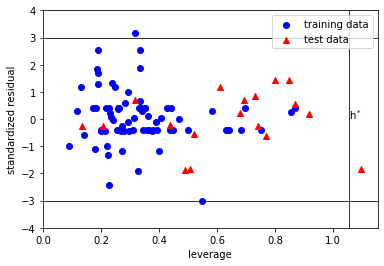

In [14]:
applicability_domainV2(scale_x_train, scale_x_test, y_train,
                     y_train_pred, y_test, y_test_pred)

# LINEAR

In [16]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 1,
            'degree': 1,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model_lin = SVR(kernel="linear", C= c, degree= deg, epsilon=eps)

model_lin.fit(scale_x_train, y_train)
y_train_pred = model_lin.predict(scale_x_train)
y_test_pred = model_lin.predict(scale_x_test)

q2_lin = q2_loo(model_lin, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_lin, pd.DataFrame(qsar_param(y_train, y_train_pred)), pd.DataFrame(qsar_param(y_test, y_test_pred))

(array([0.57862683]),
          r2         k    k_dash      r2r0  r2r0_dash  r0r0_dash  rm2_bar  \
 0  0.672282  1.038069  0.886641  0.079802   0.012161   0.045474  0.56403   
 
       d_rm2  
 0  0.094929  ,
          r2         k    k_dash      r2r0  r2r0_dash  r0r0_dash  rm2_bar  \
 0  0.516507  1.304189  0.667768  0.424787   0.008163   0.215189  0.37877   
 
       d_rm2  
 0  0.208398  )

In [17]:
rp_lin = y_random(model_lin,scale_x_train,y_train)
rp_lin

array([0.62253378])

1.054054054054054


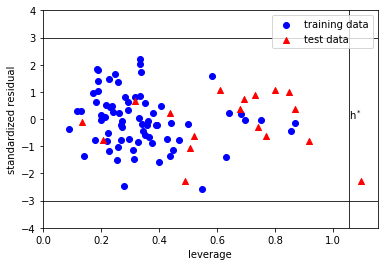

In [18]:
applicability_domainV2(scale_x_train, scale_x_test, y_train,
                     y_train_pred, y_test, y_test_pred)

# POLY

In [19]:
desc = joblib.load('./pickle/with_temp/best_25neue_force1.pkl')
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 1,
            'degree': 2,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model_pol = SVR(kernel="poly", C= c, degree= deg, epsilon=eps)
model_pol.fit(scale_x_train,y_train)
y_train_pred = model_pol.predict(scale_x_train)
y_test_pred = model_pol.predict(scale_x_test)

q2_poly = q2_loo(model_pol, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_poly, pd.DataFrame(qsar_param(y_train, y_train_pred)), pd.DataFrame(qsar_param(y_test, y_test_pred))

(array([0.61290594]),
          r2        k    k_dash      r2r0  r2r0_dash  r0r0_dash   rm2_bar  \
 0  0.692445  1.08326  0.831143  0.245321    0.00751   0.164671  0.524781   
 
      d_rm2  
 0  0.23546  ,
          r2         k   k_dash      r2r0  r2r0_dash  r0r0_dash   rm2_bar  \
 0  0.514195  1.357086  0.59306  1.121682   0.025024   0.563897  0.289779   
 
       d_rm2  
 0  0.332178  )

In [20]:
rp_poly = y_random(model_pol,scale_x_train,y_train)
rp_poly

array([0.61204923])

1.054054054054054


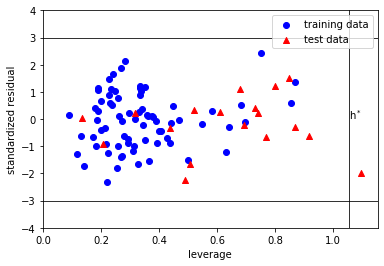

In [58]:
applicability_domainV2(X_train, X_test, y_train,
                     y_train_pred, y_test, y_test_pred)

# Merge

In [ ]:
summ = pd.DataFrame(val_rbf)
summ = summ.append(val_lin)
summ = summ.append(val_poly)
summ.insert(loc=0, column='Kernel', value=['RBF',"Linear","Poly"])
summ
# summ.insert(loc=idx, column='A', value=new_col)

In [28]:
### OLD CODE RBF

#TEST RBF
model.fit(scale_x_train, y_train)

y_ts_pred = model.predict(scale_x_test)
q_r2 = r2_score(y_test, y_ts_pred)

# print(q_too, q_r2)
qsar_param(y_test, y_ts_pred)

{'r2': array([0.70162797]),
 'k': 1.1897637873533298,
 'k_dash': 0.7820614166059207,
 'r2r0': array([0.11428953]),
 'r2r0_dash': array([0.00065712]),
 'r0r0_dash': array([0.07972768]),
 'rm2_bar': array([0.5947531]),
 'd_rm2': array([0.18361886])}

In [21]:
model.fit(scale_x_train,y_train)
q2_v2_rbf = q2_looV2(model, scale_x_train, y_train)
qsar_par_rbf = qsar_param(y_train, q2_v2_rbf[1])
q2_v2_rbf[0], qsar_par_rbf

(array([0.57968023]),
 {'r2': array([0.59760473]),
  'k': 1.0134939897416428,
  'k_dash': 0.9008102669044098,
  'r2r0': array([0.02436901]),
  'r2r0_dash': array([0.14463904]),
  'r0r0_dash': array([0.07187394]),
  'rm2_bar': array([0.47369765]),
  'd_rm2': array([0.1035794])})

In [29]:
model.fit(scale_x_train, y_train)
y_test_pred = model.predict(scale_x_test)
qsar_par_rbf = qsar_param(y_test, y_test_pred)
qsar_par_rbf

{'r2': array([0.70162797]),
 'k': 1.1897637873533298,
 'k_dash': 0.7820614166059207,
 'r2r0': array([0.11428953]),
 'r2r0_dash': array([0.00065712]),
 'r0r0_dash': array([0.07972768]),
 'rm2_bar': array([0.5947531]),
 'd_rm2': array([0.18361886])}

In [22]:
val_rbf = pd.DataFrame(qsar_par_rbf)
val_rbf['rp'] = rp
val_rbf['q2'] = q2_v2_rbf[0]
val_rbf

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,rp,q2
0,0.597605,1.013494,0.90081,0.024369,0.144639,0.071874,0.473698,0.103579,0.626982,0.57968


In [ ]:
#Predict x_test
model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

In [ ]:
#### OLD CODE LINEAR
model_lin.fit(scale_x_train, y_train)
q2_v2_lin = q2_looV2(model_lin, scale_x_train, y_train)
qsar_par_lin = qsar_param(y_train, q2_v2_lin[1])
q2_v2_lin[0], qsar_par_lin

In [ ]:
model_lin.fit(scale_x_train, y_train)
y_test_pred = model_lin.predict(scale_x_test)
qsar_par_lin = qsar_param(y_test, y_test_pred)
qsar_par_lin

In [ ]:
qsar_par_lin = qsar_param(y_train, q2_v2_lin[1])

In [ ]:
#Predict x_test
model_lin.fit(scale_x_train, y_train)
y_train_pred = model_lin.predict(scale_x_train)
y_test_pred = model_lin.predict(scale_x_test)

In [ ]:
val_lin = pd.DataFrame(qsar_par_lin)
val_lin['rp'] = rp_lin
val_lin['q2'] = q2_v2_lin[0]
val_lin

In [ ]:
#### OLD CODE POLYNOMIAL
modelPol.fit(scale_x_train,y_train)
q2_v2_poly = q2_looV2(modelPol, scale_x_train, y_train)
qsar_par_poly = qsar_param(y_train, q2_v2_poly[1])
q2_v2_poly[0], qsar_par_poly

In [ ]:
modelPol.fit(scale_x_train, y_train)
y_test_pred = modelPol.predict(scale_x_test)
qsar_par_rbf = qsar_param(y_test, y_test_pred)
qsar_par_rbf

In [ ]:
qsar_par_poly = qsar_param(y_train, q2_v2_poly[1])
pd.DataFrame(qsar_par_poly)

In [ ]:
val_poly = pd.DataFrame(qsar_par_poly)
val_poly['rp'] = rp_poly
val_poly['q2'] = q2_v2_poly[0]
val_poly

In [ ]:
#Predict x_test
modelPol.fit(scale_x_train, y_train)
y_train_pred = modelPol.predict(scale_x_train)
y_test_pred = modelPol.predict(scale_x_test)